<a href="https://colab.research.google.com/github/Dinmir331/Semester8/blob/main/S8_CV_LB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Описание**

1 лаба -- Фильтрация изображений, свёртки, морфологические операции над изображением нужно провести без использования библиотек компьютерного зрения. Можно только NumPy

2 лаба -- нужно взять 2 изображения (2 фотки пола например со сдвигом на сколько то сантиметров) или более и построить траекторию движения камеры, выполнив следующие пункты
Определите на каждой фотографии ключевые точки
Отфильтруйте самые наилучшие применяя адаптивный радиус и локальные максимумы, не забудьте так же выровнять по яркости изображения.
Постройте по каждой точке дескриптор (можете использовать любой, рекомендуется SIFT)
Сопоставьте два соседних изображения на предмет соответствия ключевых точек. То есть определите пары одинаковых точек.
Постройте модель преобразования изображений, учитывайте только поворот и сдвиг.
С учетом полученных моделей постройте траекторию движения камеры.

3 лаба -- Дано видео, нужно его считать (на видео бегает мыш по полу), отделить мышь от пола и найти её центр на каждом кадре видеоряда используя код разумеется, а не покадровое разбиение с указанием где центр вручную.

# Загрузка библиотек и данных. функции отображения изображений

## Основные библиотеки и подключение гугл диска

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Подключение Google Drive для загрузки изображения
from google.colab import drive
drive.mount('/content/drive')

# Чтение изображения с использованием OpenCV и преобразование его в RGB
image_path = '/content/drive/MyDrive/Colab Notebooks/IMAGE2.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование из BGR в RGB

Mounted at /content/drive


## Функция для отображения изображения


In [ ]:
# Функция для отображения изображения
def show_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Функция для отображения пары изображений
def show_images_pair(original, processed, title_original='Original', title_processed='Processed'):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title(title_original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed)
    plt.title(title_processed)
    plt.axis('off')
    plt.show()

# Функция для отображения каналов R, G, B
def show_channels(image, title_prefix=''):
    channels = ['Red', 'Green', 'Blue']

    # Основной заголовок над всеми каналами
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{title_prefix} Channels', fontsize=16, y=1.05)

    for i, channel in enumerate(channels):
        plt.subplot(1, 3, i+1)
        plt.imshow(image[:, :, i], cmap='gray')
        plt.title(f'{channel} Channel')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Создание краев для изображения

In [ ]:
def apply_padding(image, kernel_size=21, mode='edge'):
    pad = kernel_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode=mode)
    return padded_image

# Применение паддинга
padded_image = apply_padding(image)

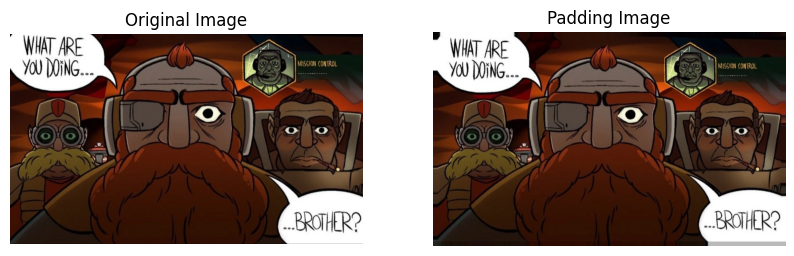

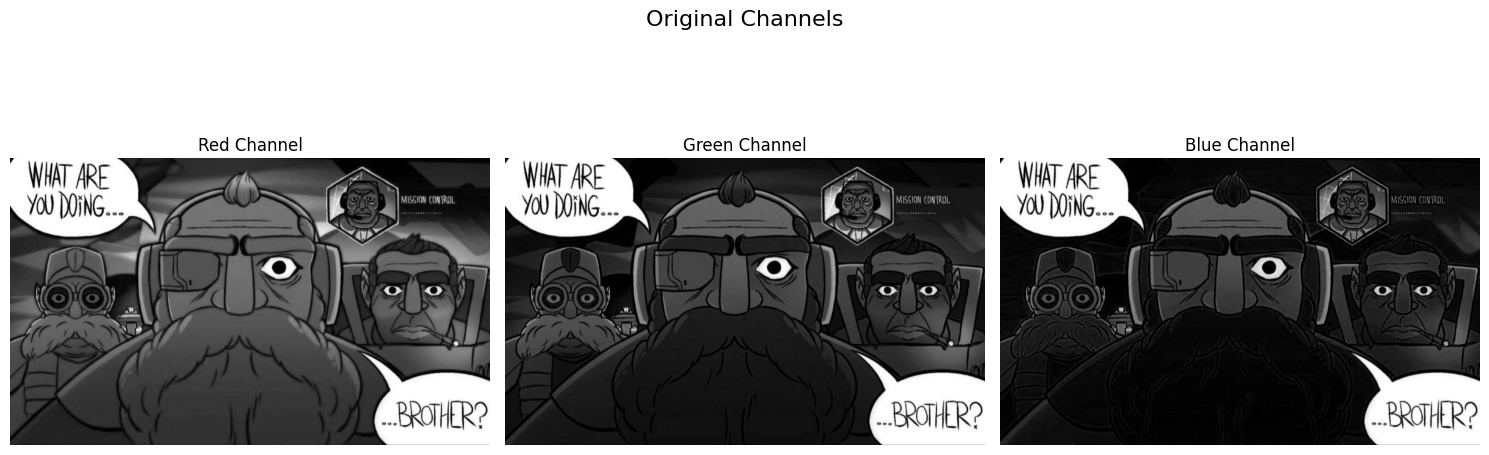

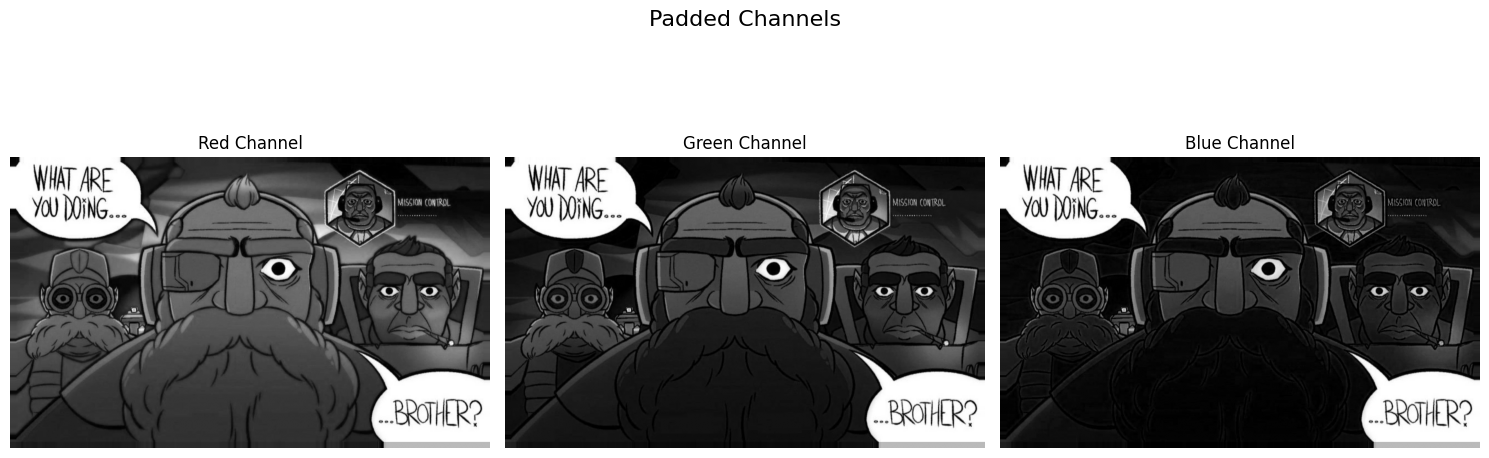

In [ ]:
# Отображение результатов паддинга
show_images_pair(image, padded_image, "Original Image", "Padding Image")
show_channels(image, "Original")
show_channels(padded_image, "Padded")

# 1. Морфологические операции: Эрозия и дилатация

## Эрозия

In [ ]:
# Эрозия изображения — уменьшение яркости пикселей
def erosion(image, kernel_size=9):
    pad = kernel_size // 2
    result = np.zeros_like(image)
    for i in range(pad, image.shape[0] - pad):
        for j in range(pad, image.shape[1] - pad):
            result[i - pad, j - pad] = np.min(image[i-pad:i+pad+1, j-pad:j+pad+1], axis=(0, 1))
    return result

# Применение эрозии
eroded_image = erosion(padded_image)

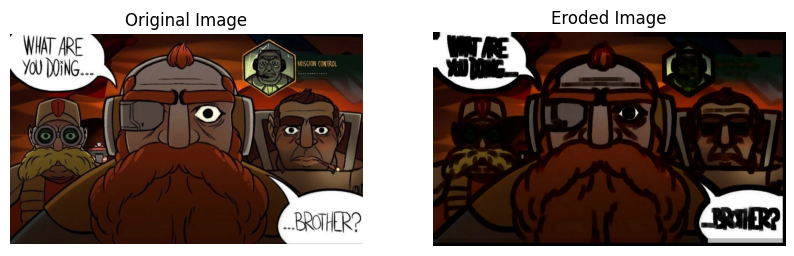

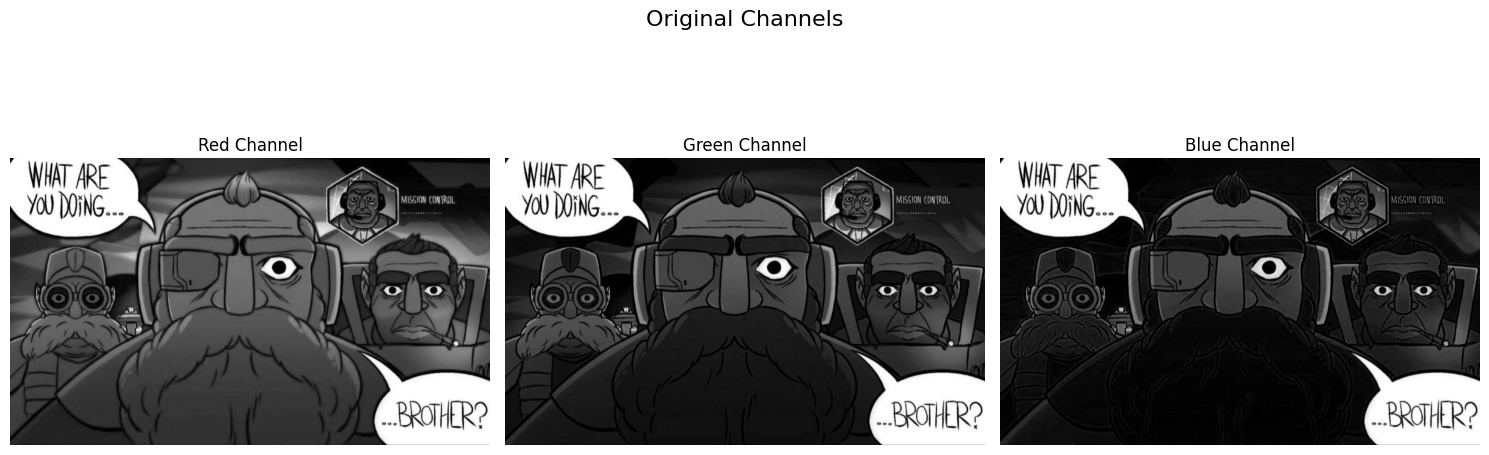

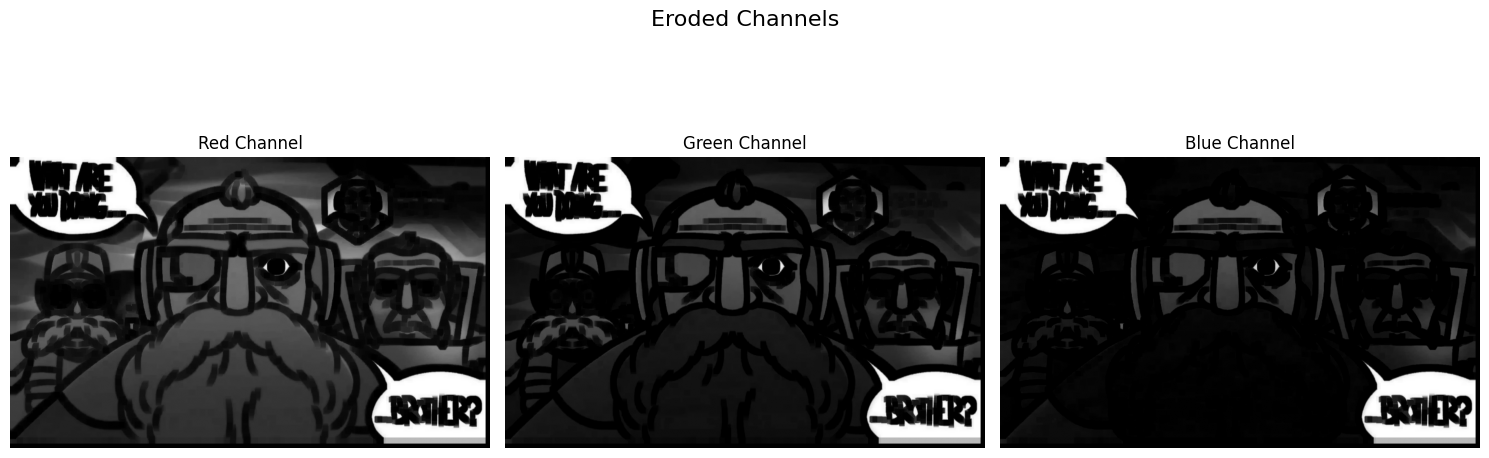

In [ ]:
# Отображение результатов эрозии
show_images_pair(image, eroded_image, "Original Image", "Eroded Image")
show_channels(image, "Original")
show_channels(eroded_image, "Eroded")

## Дилатация

In [ ]:
# Дилатация изображения — увеличение яркости пикселей
def dilation(image, kernel_size=9):
    pad = kernel_size // 2
    result = np.zeros_like(image)
    for i in range(pad, image.shape[0] - pad):
        for j in range(pad, image.shape[1] - pad):
            result[i - pad, j - pad] = np.max(image[i-pad:i+pad+1, j-pad:j+pad+1], axis=(0, 1))
    return result

# Применение дилатации
dilated_image = dilation(padded_image)

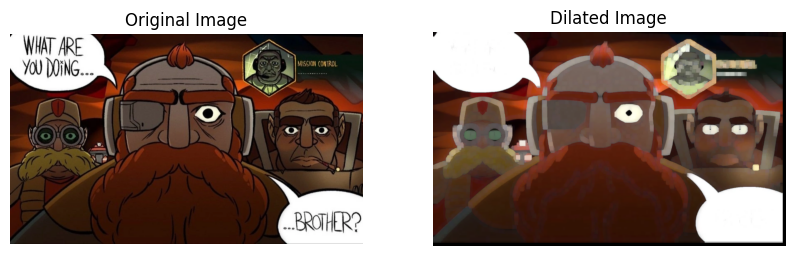

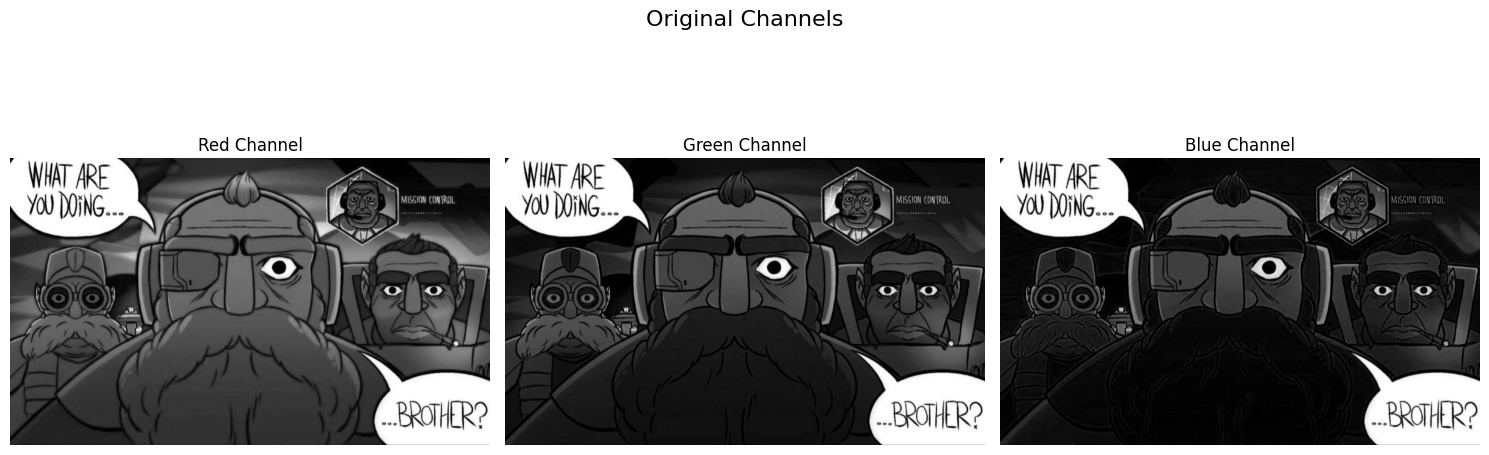

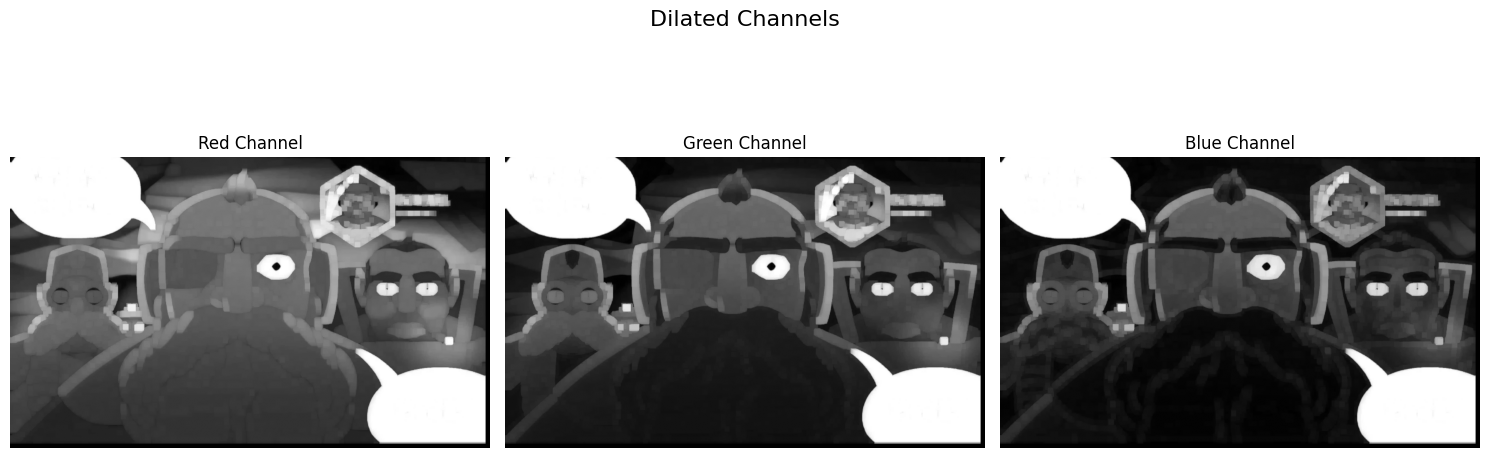

In [ ]:
# Отображение результатов дилатации
show_images_pair(image, dilated_image, "Original Image", "Dilated Image")
show_channels(image, "Original")
show_channels(dilated_image, "Dilated")

# 2. Фильтры: Гауссов фильтр и медианный фильтр

## Гауссов фильтр

In [ ]:
# Гауссов фильтр — сглаживание изображения
def gaussian_filter(image, kernel_size=9, sigma=1.0):
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    kernel /= np.sum(kernel)

    pad = kernel_size // 2
    result = np.zeros_like(image)
    for i in range(pad, image.shape[0] - pad):
        for j in range(pad, image.shape[1] - pad):
            for k in range(3):
                result[i - pad, j - pad, k] = np.sum(kernel * image[i-pad:i+pad+1, j-pad:j+pad+1, k])
    return result.astype(np.uint8)

# Применение гауссова фильтра
gaussian_filtered = gaussian_filter(padded_image)

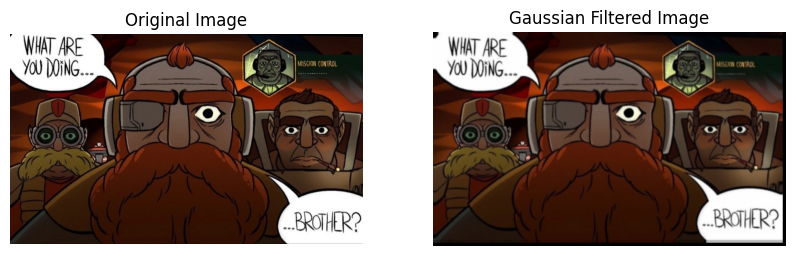

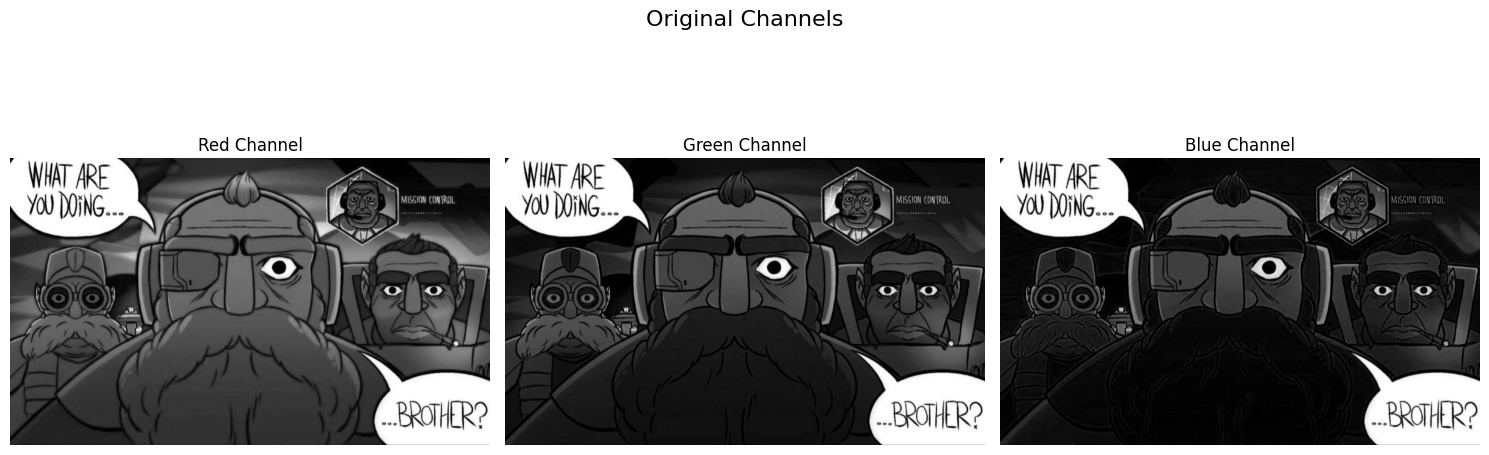

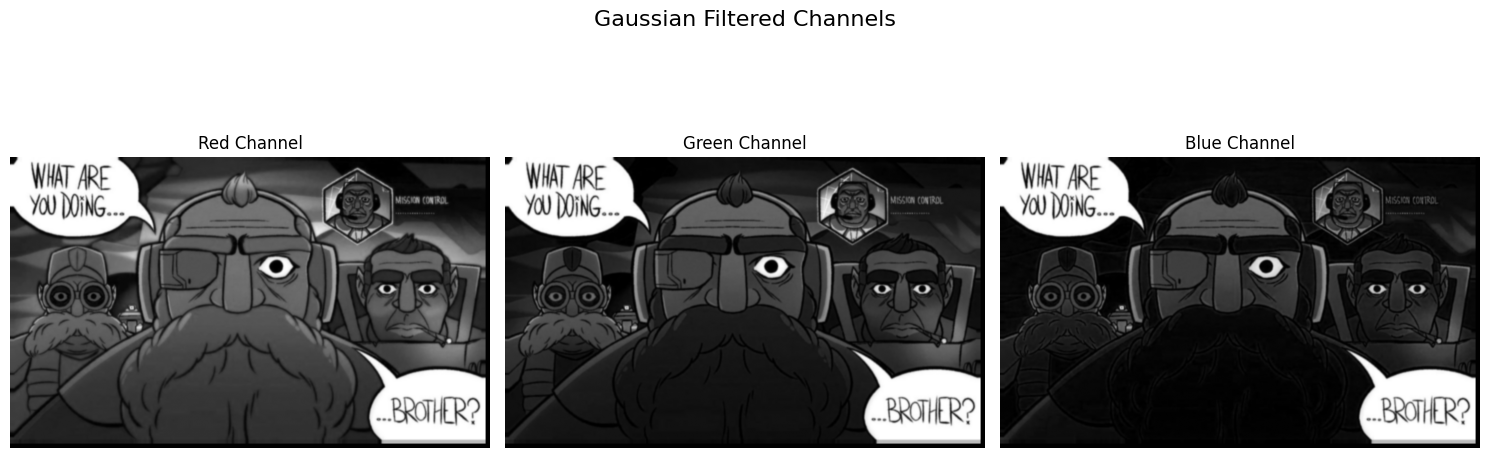

In [ ]:
# Отображение результатов гауссова фильтра
show_images_pair(image, gaussian_filtered, "Original Image", "Gaussian Filtered Image")
show_channels(image, "Original")
show_channels(gaussian_filtered, "Gaussian Filtered")

## Медианный фильтр

In [ ]:
# Медианный фильтр — удаление шумов
def median_filter(image, kernel_size=9):
    pad = kernel_size // 2
    result = np.zeros_like(image)
    for i in range(pad, image.shape[0] - pad):
        for j in range(pad, image.shape[1] - pad):
            for k in range(3):
                result[i - pad, j - pad, k] = np.median(image[i-pad:i+pad+1, j-pad:j+pad+1, k])
    return result

# Применение медианного фильтра
median_filtered = median_filter(padded_image)

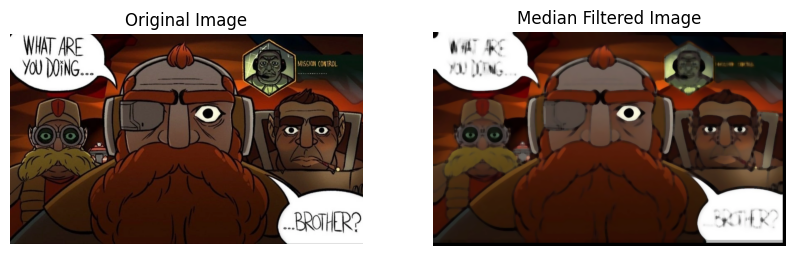

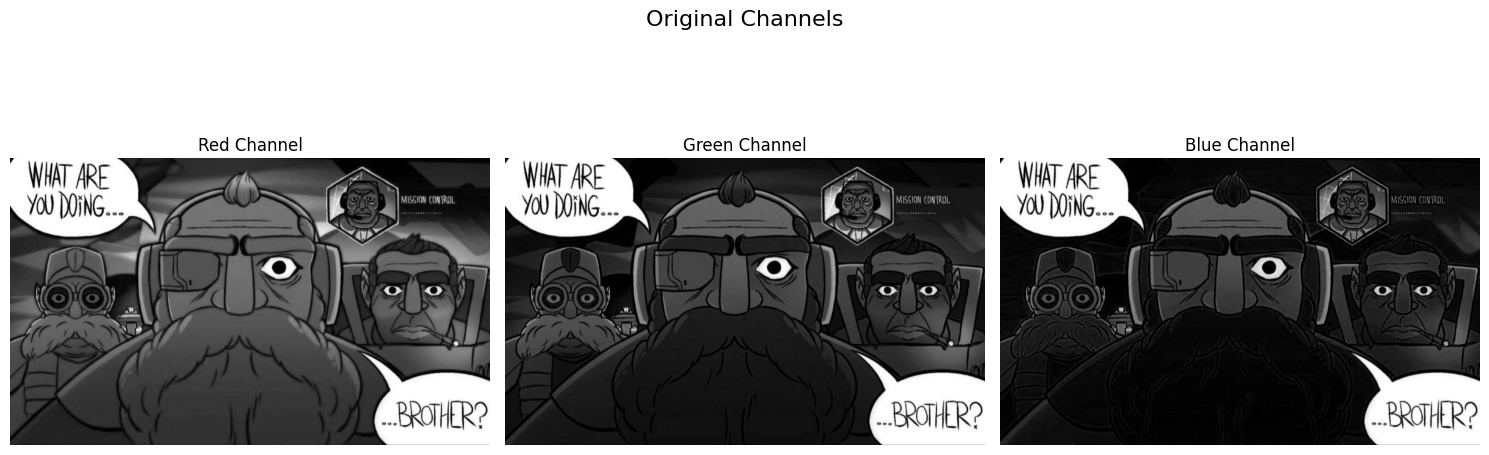

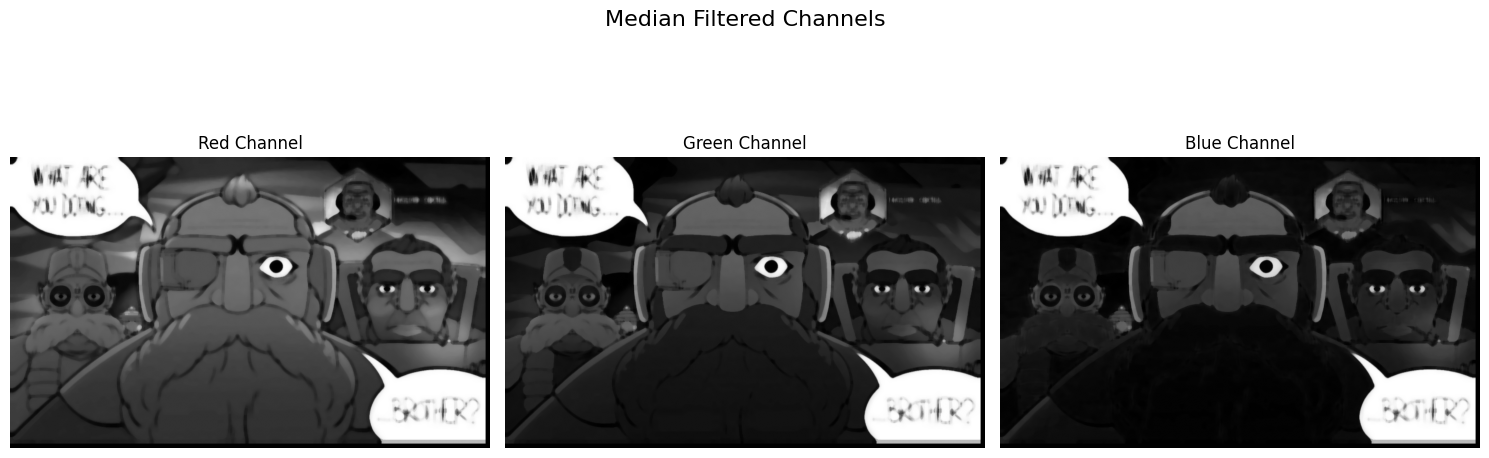

In [ ]:
# Отображение результатов медианного фильтра
show_images_pair(image, median_filtered, "Original Image", "Median Filtered Image")
show_channels(image, "Original")
show_channels(median_filtered, "Median Filtered")

# 3. Бинаризация изображения

In [ ]:
# # Бинаризация изображения — преобразование в черно-белое изображение по порогу
# def binarize_image(image, threshold=128):
#     grayscale = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
#     binary_image = (grayscale > threshold).astype(np.uint8) * 255
#     return np.stack([binary_image] * 3, axis=-1)

# Бинаризация изображения — пороговое преобразование для каждого канала
def binarize_image(image, threshold=128):
    binary_image = np.zeros_like(image)
    for i in range(3):  # Применение порогового преобразования к каждому каналу
        binary_image[:, :, i] = (image[:, :, i] > threshold).astype(np.uint8) * 255
    return binary_image

# Применение бинаризации
binary_image = binarize_image(image)

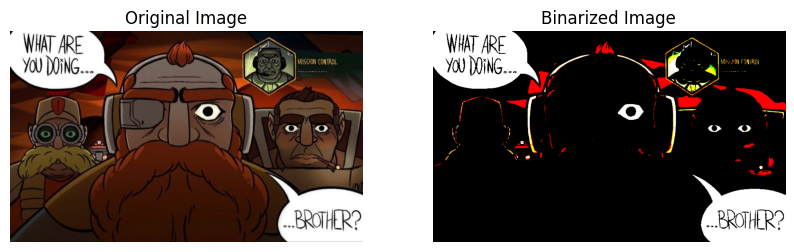

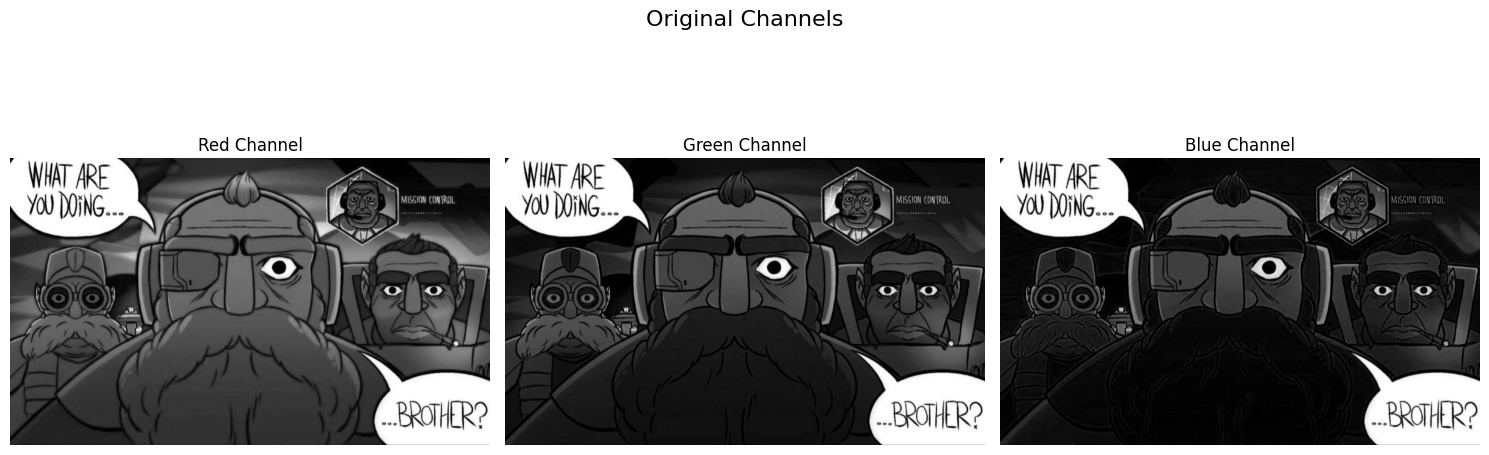

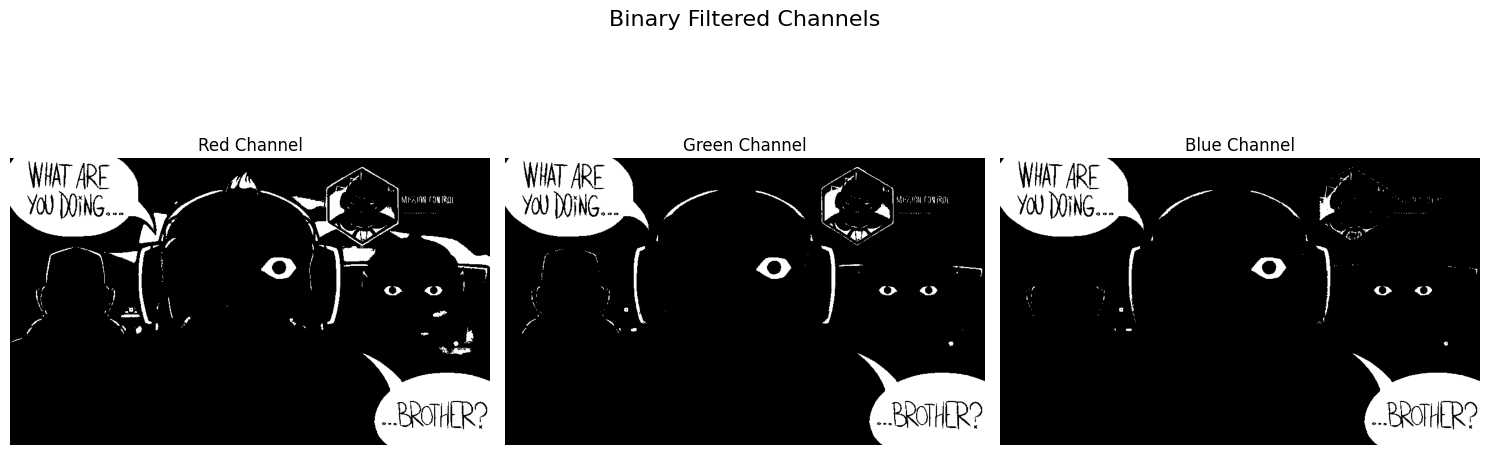

In [ ]:
# Отображение бинаризованного изображения
show_images_pair(image, binary_image, "Original Image", "Binarized Image")
show_channels(image, "Original")
show_channels(binary_image, "Binary Filtered")

# 4. Коррекция яркости/освещенности

In [ ]:
# Коррекция яркости — увеличение яркости на основе коэффициента
def adjust_brightness(image, factor=2.0):
    result = np.clip(image * factor, 0, 255)
    return result.astype(np.uint8)

# Применение коррекции яркости
brightened_image = adjust_brightness(image)

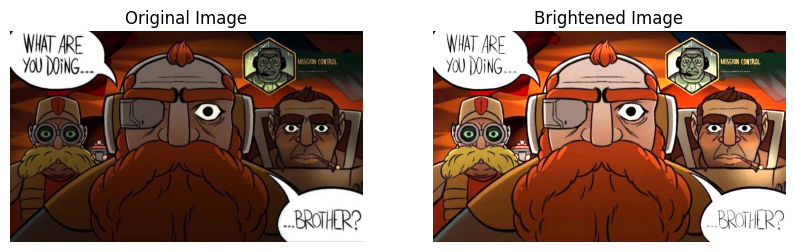

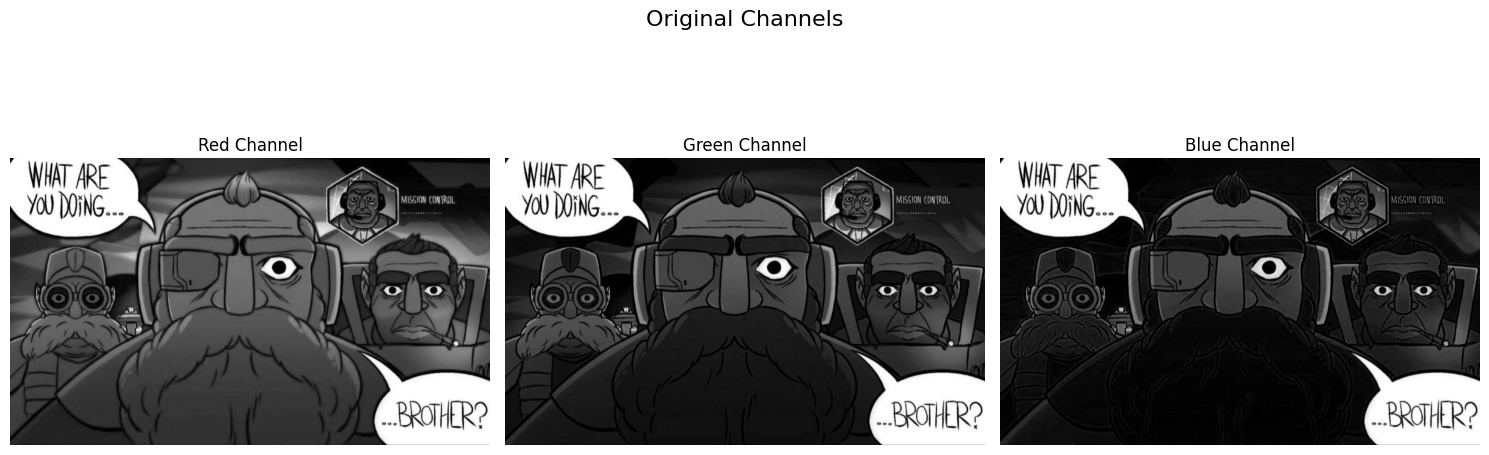

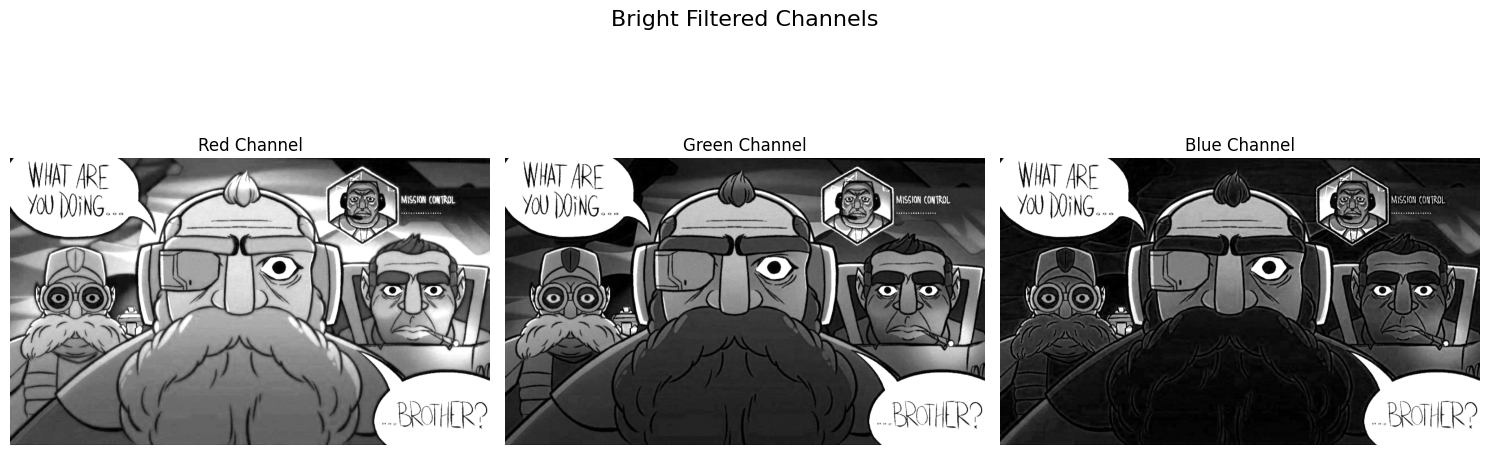

In [ ]:
show_images_pair(image, brightened_image, "Original Image", "Brightened Image")
show_channels(image, "Original")
show_channels(brightened_image, "Bright Filtered")